In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
pd.set_option('display.max_columns', 500)

In [3]:
DF_train = pd.read_csv('CNS_gas_train.csv')
DF_test = pd.read_csv('CNS_gas_test.csv', dtype='object')
CNS_oil = pd.read_csv('CNS oil.csv')
CNS_rock = pd.read_csv('CNS rock samples.csv')
CNS_Fieldprod = pd.read_csv('CNS_Field_Production.csv')

In [4]:
DF_train.head(3)

,Country,WELL_NAME,OGA Well Name,WH_SITETYPE,WH_FIELD,WH_BLOCK,WH_LAT,WH_LONG,WH_COORD_SYS,WH_OPERATOR,WH_SPUD_DATE,WH_SPUD_YEAR,WH_COMP_DATE,WH_TD_M,WH_DR_ELEV_M,WH_DEPTH_REF,WH_WATER_DEPTH_M,SAMPLE_ID,SH_DEPTH_TOP_FT,SH_DEPTH_BOT_FT,SH_SAMPLE_TYPE,SH_SAMPLE_SUB_TYPE,SH_ORIG,SH_ORIG_DESC,SH_TREATMENT,SH_TREATMENT_DESC,SH_LITH,SH_AGE,SH_AGE_BOT,SH_FORM,SH_FORM_BOT,SH_CDATE,SH_COMMENT,SAMPLE_ID_GM,SAMPLE_ID_GDB,SAMPLE_ID_SAM,EXT_SAMPLE_VENDOR,SAMPLE_ID_EXT,GAS_METHOD,GAS_LAB,GAS_ACQ_DATE,GAS_TOTAL_CONCENTRATION,GAS_AIR,GAS_C1,GAS_C2,C2_UNSAT,GAS_C3,C3_UNSAT,GAS_IC4,GAS_NC4,C4_UNSAT,GAS_NEOC5,GAS_IC5,GAS_NC5,C5_UNSAT,GAS_NC5_PLUS,GAS_C6PLUS,GAS_O2,GAS_CO2,GAS_H2,GAS_H2S,GAS_HE,GAS_N2,D_G_METHOD,D_G_LAB,D_G_DATA_TYPE,D_G_ACQ_DATE,CSIA_CONC_C1,CSIA_NC1,CSIA_NC2,CSIA_NC3,CSIA_IC4,CSIA_NC4,CSIA_NEOC5,CSIA_IC5,CSIA_NC5,CSIA_ETHENE,CSIA_PROPENE,DC_G_CO2,DO_G_CO2,DS_G_H2S,DD_G_H2,DN_G_N2,DD_G_GAS,DD_G_NC1,DD_G_NC2,DD_G_NC3,DD_G_IC4,DD_G_NC4,DD_G_IC5,DD_G_NC5
0,NaN,Well name,Well name,Site type,Field name,Block name,Latitude,Longitude,Location CRS,Operator,Spud date,Spud year,Completion date,Target depth (m),Derrick floor elevation (m),Depth reference,Water depth (m),Sample code,Top depth in feet,Base depth in feet,Sample type,Sample origin/sub-type,Sample origin,Sample origin description,Sample treatment,Sample treatment description,Sample lithology,Sample age (top),Sample age (bottom),Formation (top),Formation (bottom),Collection date,Sample comments,Sample code GM,Sample code in GDB,Sample code in SAM,Name external data vendor,Sample code external data vendor,Method used,Laboratory,Acquisition date,Total gas concentration (ppm),Air in original sample Mol%,Methane air free Mol%,Ethane air free Mol%,C2 unsaturated air free Mol%,Propane air free Mol%,C3 unsaturated air free Mol%,Iso butane air free Mol%,Normal butane air free Mol%,C4 unsaturated air free Mol%,Neo pentane %,Iso pentane air free Mol%,Normal pentane air free Mol%,C5 unsaturated air free Mol%,C5+ fraction air free Mol%,C6+ fraction air free Mol%,Oxygen,CO2 air free Mol%,Hydrogen air free Mol%,H2S air free Mol%,HE air free Mol%,Nitrogen air free Mol%,Method used,Laboratory,Data type,Acquisition date,vol% C1,dC13 nC1,dC13 nC2,dC13 nC3,dC13 iC4,dC13 nC4,dC13 neopentane,dC13 iC5,dC13 nC5,ethene,propene,dC13 CO2,dO18 CO2,dS34 H2S,dDeuterium on H2,dN15 N2,dDeuterium total GAS,dDeuterium nC1,dDeuterium nC2,dDeuterium nC3,dDeuterium iC4,dDeuterium nC4,dDeuterium iC5,dDeuterium nC5
1,United Kingdom,023/22A-A12 (A12),23/22a-A12,WELL,PIERCE,023/22a,NaN,NaN,NaN,SHELL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXPRO_41219,9814,12360,Gas,Subsurface,SEPR,NaN,ASIS,NaN,NaN,NaN,NaN,SELE,NaN,30-03-16 0:00,1379-C1-F,NaN,NaN,NaN,NaN,NaN,Air corrected,ISOLAB,23-05-16 0:00,NaN,0.069,75.5,11.4,0.0019,6.1,0.0008,1,2.1,NaN,0.0085,0.51,0.53,NaN,NaN,0.5,NaN,1.8,0,0,NaN,0.56,CSIA,ISOLAB,per mil,23-05-16 0:00,NaN,-42.1,-28.8,-28.2,-29,-28.5,NaN,-28.2,-28.7,NaN,NaN,-7.7,NaN,NaN,NaN,-4,NaN,-187,NaN,NaN,NaN,NaN,NaN,NaN
2,United Kingdom,023/22A-A12 (A12),23/22a-A12,WELL,PIERCE,023/22a,NaN,NaN,NaN,SHELL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXPRO_41220,9814,12360,Gas,Subsurface,SEPR,NaN,ASIS,NaN,NaN,NaN,NaN,SELE,NaN,30-03-16 0:00,A2442,NaN,NaN,NaN,NaN,NaN,Air corrected,ISOLAB,23-05-16 0:00,NaN,0.021,75.4,11.2,0.0017,6.1,0.0007,1.1,2.2,NaN,0.0087,0.54,0.57,NaN,NaN,0.58,NaN,1.8,0,0,NaN,0.57,CSIA,ISOLAB,per mil,23-05-16 0:00,NaN,-42.1,-28.8,-28.2,-29,-28.5,NaN,-28.2,-28.7,NaN,NaN,-7.6,NaN,NaN,NaN,-3.7,NaN,-187,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
X = DF_train.drop(['Country', 'OGA Well Name', 'WH_COORD_SYS', 'WH_SPUD_DATE',
               'WH_COMP_DATE', 'WH_DEPTH_REF', 'WH_WATER_DEPTH_M', 'SAMPLE_ID',
               'SH_SAMPLE_TYPE', 'SH_ORIG_DESC', 'SH_TREATMENT_DESC',
               'SH_LITH', 'SH_AGE', 'SH_AGE_BOT', 'SH_FORM_BOT', 'SH_COMMENT',
               'SAMPLE_ID_GM', 'SAMPLE_ID_SAM', 'EXT_SAMPLE_VENDOR', 'SAMPLE_ID_EXT', 
               'GAS_TOTAL_CONCENTRATION', 'GAS_C1', 'GAS_C2', 'GAS_C3', 'C3_UNSAT', 'GAS_IC4', 
               'GAS_NC4', 'C4_UNSAT', 'GAS_IC5', 'GAS_NC5', 'C5_UNSAT', 'GAS_NC5_PLUS', 
               'GAS_H2S', 'GAS_HE', 'D_G_DATA_TYPE', 'CSIA_NEOC5', 'DS_G_H2S', 
               'DD_G_H2', 'DO_G_CO2', 'DN_G_N2', 'DD_G_GAS', 'DD_G_NC1', 'DD_G_NC2',
               'DD_G_NC3', 'DD_G_IC4', 'DD_G_NC4', 'DD_G_IC5', 'DD_G_NC5',
               'SH_CDATE', 'GAS_ACQ_DATE', 'D_G_ACQ_DATE', 
               'WELL_NAME', 'WH_SITETYPE', 'WH_FIELD', 'WH_BLOCK', 'SH_FORM'], axis=1)
Y =  DF_train[['GAS_C1', 'GAS_C2', 'GAS_C3', 'GAS_IC4', 'GAS_NC4', 'GAS_IC5', 'GAS_NC5']]
X = X.drop(0)
Y = Y.drop(0)
for col in X.columns:
    X[col] = X[col].str.upper()

In [7]:
Y.head(1)

,GAS_C1,GAS_C2,GAS_C3,GAS_IC4,GAS_NC4,GAS_IC5,GAS_NC5
1,75.5,11.4,6.1,1,2.1,0.51,0.53


In [8]:
Y1 = Y[['GAS_C1']]

In [9]:
X.head(2)

,WH_LAT,WH_LONG,WH_OPERATOR,WH_SPUD_YEAR,WH_TD_M,WH_DR_ELEV_M,SH_DEPTH_TOP_FT,SH_DEPTH_BOT_FT,SH_SAMPLE_SUB_TYPE,SH_ORIG,SH_TREATMENT,SAMPLE_ID_GDB,GAS_METHOD,GAS_LAB,GAS_AIR,C2_UNSAT,GAS_NEOC5,GAS_C6PLUS,GAS_O2,GAS_CO2,GAS_H2,GAS_N2,D_G_METHOD,D_G_LAB,CSIA_CONC_C1,CSIA_NC1,CSIA_NC2,CSIA_NC3,CSIA_IC4,CSIA_NC4,CSIA_IC5,CSIA_NC5,CSIA_ETHENE,CSIA_PROPENE,DC_G_CO2,SAMPLE_ID_name
1,NaN,NaN,SHELL,NaN,NaN,NaN,9814,12360,SUBSURFACE,SEPR,ASIS,NaN,AIR CORRECTED,ISOLAB,0.069,0.0019,0.0085,0.5,NaN,1.8,0,0.56,CSIA,ISOLAB,NaN,-42.1,-28.8,-28.2,-29,-28.5,-28.2,-28.7,NaN,NaN,-7.7,EXPRO
2,NaN,NaN,SHELL,NaN,NaN,NaN,9814,12360,SUBSURFACE,SEPR,ASIS,NaN,AIR CORRECTED,ISOLAB,0.021,0.0017,0.0087,0.58,NaN,1.8,0,0.57,CSIA,ISOLAB,NaN,-42.1,-28.8,-28.2,-29,-28.5,-28.2,-28.7,NaN,NaN,-7.6,EXPRO


In [131]:
# TIME = X[['SH_CDATE', 'GAS_ACQ_DATE', 'D_G_ACQ_DATE']]
# TIME.head(2)

,SH_CDATE,GAS_ACQ_DATE,D_G_ACQ_DATE
1,30-03-16 0:00,23-05-16 0:00,23-05-16 0:00
2,30-03-16 0:00,23-05-16 0:00,23-05-16 0:00


In [133]:
# TIME = TIME.replace(np.nan, '01-01-99 0:00')

In [134]:
# TIME.loc[:, 'SH_CDATE'] = TIME.loc[:, 'SH_CDATE'].apply(lambda x: dt.datetime.timestamp(dt.datetime.strptime(str(x),'%d-%m-%y %H:%M')))
# TIME.loc[:, 'GAS_ACQ_DATE'] = TIME.loc[:, 'GAS_ACQ_DATE'].apply(lambda x: dt.datetime.timestamp(dt.datetime.strptime(str(x),'%d-%m-%y %H:%M')))
# TIME.loc[:, 'D_G_ACQ_DATE'] = TIME.loc[:, 'D_G_ACQ_DATE'].apply(lambda x: dt.datetime.timestamp(dt.datetime.strptime(str(x),'%d-%m-%y %H:%M')))

In [10]:
NOT_CAT = X.drop(['WH_OPERATOR', 'SH_SAMPLE_SUB_TYPE', 'D_G_METHOD',
         'SH_ORIG', 'SH_TREATMENT', 'GAS_METHOD', 'GAS_LAB', 'D_G_LAB', 'SAMPLE_ID_name'], axis=1)
NOT_CAT.head(2)

,WH_LAT,WH_LONG,WH_SPUD_YEAR,WH_TD_M,WH_DR_ELEV_M,SH_DEPTH_TOP_FT,SH_DEPTH_BOT_FT,SAMPLE_ID_GDB,GAS_AIR,C2_UNSAT,GAS_NEOC5,GAS_C6PLUS,GAS_O2,GAS_CO2,GAS_H2,GAS_N2,CSIA_CONC_C1,CSIA_NC1,CSIA_NC2,CSIA_NC3,CSIA_IC4,CSIA_NC4,CSIA_IC5,CSIA_NC5,CSIA_ETHENE,CSIA_PROPENE,DC_G_CO2
1,NaN,NaN,NaN,NaN,NaN,9814,12360,NaN,0.069,0.0019,0.0085,0.5,NaN,1.8,0,0.56,NaN,-42.1,-28.8,-28.2,-29,-28.5,-28.2,-28.7,NaN,NaN,-7.7
2,NaN,NaN,NaN,NaN,NaN,9814,12360,NaN,0.021,0.0017,0.0087,0.58,NaN,1.8,0,0.57,NaN,-42.1,-28.8,-28.2,-29,-28.5,-28.2,-28.7,NaN,NaN,-7.6


In [11]:
CAT = X[['WH_OPERATOR', 'SH_SAMPLE_SUB_TYPE',
         'SH_ORIG', 'SH_TREATMENT', 'GAS_METHOD', 'GAS_LAB', 'D_G_METHOD', 'D_G_LAB', 'SAMPLE_ID_name']]
CAT = CAT.replace(np.nan, 'XXXXX')

In [12]:
enc = OneHotEncoder()
enc.fit(CAT)
onehotlab = pd.DataFrame(enc.transform(CAT).toarray())

In [13]:
NOT_CAT = NOT_CAT.reset_index(drop=True)
# TIME = TIME.reset_index(drop=True)

In [14]:
X_NEW = pd.concat([NOT_CAT, onehotlab], axis=1) #TIME

In [15]:
X_NEW.head(3)

,WH_LAT,WH_LONG,WH_SPUD_YEAR,WH_TD_M,WH_DR_ELEV_M,SH_DEPTH_TOP_FT,SH_DEPTH_BOT_FT,SAMPLE_ID_GDB,GAS_AIR,C2_UNSAT,GAS_NEOC5,GAS_C6PLUS,GAS_O2,GAS_CO2,GAS_H2,GAS_N2,CSIA_CONC_C1,CSIA_NC1,CSIA_NC2,CSIA_NC3,CSIA_IC4,CSIA_NC4,CSIA_IC5,CSIA_NC5,CSIA_ETHENE,CSIA_PROPENE,DC_G_CO2,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,NaN,NaN,NaN,NaN,NaN,9814,12360,NaN,0.069,0.0019,0.0085,0.5,NaN,1.8,0,0.56,NaN,-42.1,-28.8,-28.2,-29,-28.5,-28.2,-28.7,NaN,NaN,-7.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,NaN,NaN,NaN,NaN,NaN,9814,12360,NaN,0.021,0.0017,0.0087,0.58,NaN,1.8,0,0.57,NaN,-42.1,-28.8,-28.2,-29,-28.5,-28.2,-28.7,NaN,NaN,-7.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,NaN,NaN,NaN,NaN,NaN,5400,5400,NaN,NaN,NaN,NaN,NaN,NaN,0.037,NaN,NaN,1.7,-70.8,-35.5,-26.1,-26,-27,-29,-29,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [16]:
X_NEW = X_NEW.replace('WORLD GEODETIC SYSTEM 1984', '0.0')

In [17]:
X_NEW = np.array(X_NEW, dtype='float64')
Y1 = np.array(Y1, dtype='float64')

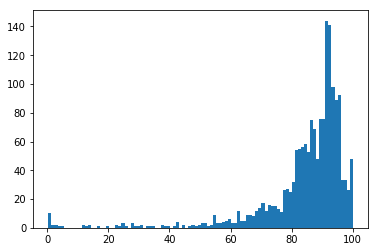

In [18]:
plt.hist(Y1, bins=100)
plt.show()

In [19]:
X_NEW.shape

(1709, 88)

In [20]:
Y.shape

(1709, 7)

In [282]:
res=[]
kf = KFold(n_splits=10, shuffle=True)
for train_index, test_index in kf.split(X_NEW):
    X_train, X_test = X_NEW[train_index], X_NEW[test_index]
    y_train, y_test = Y1[train_index], Y1[test_index]
    dtrain = xgb.DMatrix(X_train, y_train)
    dtest = xgb.DMatrix(X_test)
    param = {'max_depth':6, 'eta':0.05, 'silent':1}
    num_round = 1000
    boost = xgb.train(param, dtrain, num_round)
    y_pred = boost.predict(dtest)
    res.append(MAE(y_test, y_pred))
qual = np.mean(res)

In [283]:
qual

3.0029965329582566

In [284]:
res

[2.9325620155959093,
 2.9659701173124247,
 2.7966906962957987,
 2.8901698850977486,
 3.1027474046182917,
 2.969424780159666,
 3.080056030055933,
 3.3703580895496392,
 3.499208186340332,
 2.422778124556822]

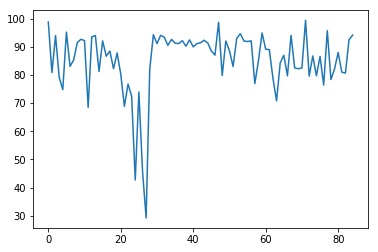

In [21]:
plt.plot(y_pred)

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 3.,
        0., 0., 2., 4., 2., 3., 1., 6., 2., 0., 1., 2., 0., 3., 2., 2., 3.,
        2., 2., 1., 7., 8., 5., 2., 6., 2., 2., 0., 0., 0., 1., 2.]),
 array([29.230373, 29.9319  , 30.633427, 31.334953, 32.03648 , 32.738007,
        33.439533, 34.14106 , 34.84259 , 35.544117, 36.245644, 36.94717 ,
        37.648697, 38.350224, 39.05175 , 39.753277, 40.454803, 41.15633 ,
        41.857857, 42.559383, 43.26091 , 43.962437, 44.663967, 45.365494,
        46.06702 , 46.768547, 47.470074, 48.1716  , 48.873127, 49.574654,
        50.27618 , 50.977707, 51.679234, 52.38076 , 53.082287, 53.783813,
        54.485344, 55.18687 , 55.888397, 56.589924, 57.29145 , 57.992977,
        58.694504, 59.39603 , 60

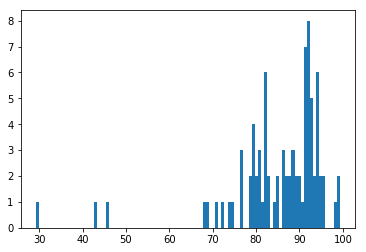

In [22]:
plt.hist(y_pred, bins=100)

In [243]:
Xt = DF_test.drop(['Country', 'OGA Well Name', 'WH_COORD_SYS', 'WH_SPUD_DATE',
               'WH_COMP_DATE', 'WH_DEPTH_REF', 'WH_WATER_DEPTH_M', 'SAMPLE_ID',
               'SH_SAMPLE_TYPE', 'SH_ORIG_DESC', 'SH_TREATMENT_DESC',
               'SH_LITH', 'SH_AGE', 'SH_AGE_BOT', 'SH_FORM_BOT', 'SH_COMMENT',
               'SAMPLE_ID_GM', 'SAMPLE_ID_SAM', 'EXT_SAMPLE_VENDOR', 'SAMPLE_ID_EXT', 
               'GAS_TOTAL_CONCENTRATION', 'GAS_C1', 'GAS_C2', 'GAS_C3', 'C3_UNSAT', 'GAS_IC4', 
               'GAS_NC4', 'C4_UNSAT', 'GAS_IC5', 'GAS_NC5', 'C5_UNSAT', 'GAS_NC5_PLUS', 
               'GAS_H2S', 'GAS_HE', 'D_G_DATA_TYPE', 'CSIA_NEOC5', 'DS_G_H2S', 
               'DD_G_H2', 'DO_G_CO2', 'DN_G_N2', 'DD_G_GAS', 'DD_G_NC1', 'DD_G_NC2',
               'DD_G_NC3', 'DD_G_IC4', 'DD_G_NC4', 'DD_G_IC5', 'DD_G_NC5',
               'SH_CDATE', 'GAS_ACQ_DATE', 'D_G_ACQ_DATE', 
               'WELL_NAME', 'WH_SITETYPE', 'WH_FIELD', 'WH_BLOCK', 'SH_FORM'], axis=1)
Yt =  DF_test[['GAS_C1', 'GAS_C2', 'GAS_C3', 'GAS_IC4', 'GAS_NC4', 'GAS_IC5', 'GAS_NC5']]
for col in Xt.columns:
    Xt[col] = Xt[col].str.upper()

In [25]:
NOT_CATt = Xt.drop(['WH_OPERATOR', 'SH_SAMPLE_SUB_TYPE', 'D_G_METHOD',
         'SH_ORIG', 'SH_TREATMENT', 'GAS_METHOD', 'GAS_LAB', 'D_G_LAB'], axis=1)
NOT_CATt.head(2)

,WH_LAT,WH_LONG,WH_SPUD_YEAR,WH_TD_M,WH_DR_ELEV_M,SH_DEPTH_TOP_FT,SH_DEPTH_BOT_FT,SAMPLE_ID_GDB,GAS_AIR,C2_UNSAT,GAS_NEOC5,GAS_C6PLUS,GAS_O2,GAS_CO2,GAS_H2,GAS_N2,CSIA_CONC_C1,CSIA_NC1,CSIA_NC2,CSIA_NC3,CSIA_IC4,CSIA_NC4,CSIA_IC5,CSIA_NC5,CSIA_ETHENE,CSIA_PROPENE,DC_G_CO2
0,NaN,NaN,NaN,NaN,NaN,7375.98,7425.98,1000132,NaN,NaN,NaN,1.49,NaN,0.59,NaN,0.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,7376,7386,143560,NaN,NaN,NaN,0.35,0,0.91,NaN,0.94,NaN,-56.3,-39.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
CATt = Xt[['WH_OPERATOR', 'SH_SAMPLE_SUB_TYPE',
         'SH_ORIG', 'SH_TREATMENT', 'GAS_METHOD', 'GAS_LAB', 'D_G_METHOD', 'D_G_LAB']]
CATt['WH_OPERATOR'].fillna('SHELL', inplace=True)
CATt = CATt.replace(np.nan, 'XXXXX')

C:\Users\mserg\Anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [27]:
CATt.head(2)

,WH_OPERATOR,SH_SAMPLE_SUB_TYPE,SH_ORIG,SH_TREATMENT,GAS_METHOD,GAS_LAB,D_G_METHOD,D_G_LAB
0,SHELL,UNSPECIFIED,XXXXX,ASIS,UNKNOWN,RTS,XXXXX,XXXXX
1,SHELL,UNSPECIFIED,XXXXX,ASIS,AIR CORRECTED,KSEPL,GCMS,KSEPL


In [28]:
onehotlabt = pd.DataFrame(enc.transform(CATt).toarray())

In [29]:
NOT_CATt = NOT_CATt.reset_index(drop=True)
# TIMEt = TIMEt.reset_index(drop=True)

In [30]:
Xt_NEW = pd.concat([NOT_CATt, onehotlabt], axis=1)

In [31]:
Xt_NEW = np.array(Xt_NEW)

In [32]:
Xt_NEW.shape

(100, 86)

In [33]:
DTEST = xgb.DMatrix(Xt_NEW)

In [34]:
Y_TEST1 = boost.predict(DTEST)

(array([1., 1., 1., 0., 4., 1., 2., 3., 1., 7., 4., 2., 2., 2., 4., 3., 4.,
        2., 0., 6., 4., 2., 7., 3., 6., 3., 1., 3., 2., 6., 9., 0., 1., 0.,
        0., 1., 1., 0., 0., 1.]),
 array([ 54.767345,  55.927933,  57.08852 ,  58.249104,  59.40969 ,
         60.57028 ,  61.730865,  62.89145 ,  64.05204 ,  65.21262 ,
         66.37321 ,  67.5338  ,  68.69438 ,  69.85497 ,  71.01556 ,
         72.17614 ,  73.33673 ,  74.497314,  75.6579  ,  76.81849 ,
         77.97907 ,  79.13966 ,  80.30025 ,  81.46083 ,  82.62142 ,
         83.782005,  84.9426  ,  86.10318 ,  87.26376 ,  88.424355,
         89.58494 ,  90.74553 ,  91.90611 ,  93.066696,  94.22729 ,
         95.38787 ,  96.548454,  97.709045,  98.86963 , 100.03022 ,
        101.1908  ], dtype=float32),
 <a list of 40 Patch objects>)

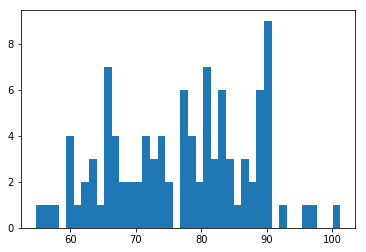

In [36]:
plt.hist(Y_TEST1, bins=40)

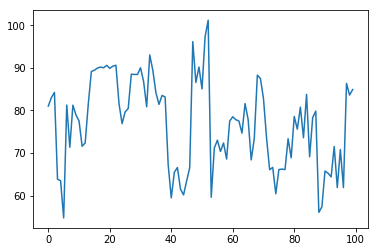

In [38]:
plt.plot(Y_TEST1)

In [244]:
NOT_CAT = X.drop(['WH_OPERATOR', 'SH_SAMPLE_SUB_TYPE', 'D_G_METHOD',
         'SH_ORIG', 'SH_TREATMENT', 'GAS_METHOD', 'GAS_LAB', 'D_G_LAB'], axis=1)
NOT_CAT.head(2)

,WH_LAT,WH_LONG,WH_SPUD_YEAR,WH_TD_M,WH_DR_ELEV_M,SH_DEPTH_TOP_FT,SH_DEPTH_BOT_FT,SAMPLE_ID_GDB,GAS_AIR,C2_UNSAT,GAS_NEOC5,GAS_C6PLUS,GAS_O2,GAS_CO2,GAS_H2,GAS_N2,CSIA_CONC_C1,CSIA_NC1,CSIA_NC2,CSIA_NC3,CSIA_IC4,CSIA_NC4,CSIA_IC5,CSIA_NC5,CSIA_ETHENE,CSIA_PROPENE,DC_G_CO2
1,NaN,NaN,NaN,NaN,NaN,9814,12360,NaN,0.069,0.0019,0.0085,0.5,NaN,1.8,0,0.56,NaN,-42.1,-28.8,-28.2,-29,-28.5,-28.2,-28.7,NaN,NaN,-7.7
2,NaN,NaN,NaN,NaN,NaN,9814,12360,NaN,0.021,0.0017,0.0087,0.58,NaN,1.8,0,0.57,NaN,-42.1,-28.8,-28.2,-29,-28.5,-28.2,-28.7,NaN,NaN,-7.6


In [245]:
CAT = X[['WH_OPERATOR', 'SH_SAMPLE_SUB_TYPE',
         'SH_ORIG', 'SH_TREATMENT', 'GAS_METHOD', 'GAS_LAB', 'D_G_METHOD', 'D_G_LAB']]
CAT = CAT.replace(np.nan, 'XXXXX')

In [246]:
X_NEW = pd.concat([CAT, NOT_CAT], axis=1)

In [247]:
X_NEW.head(2)

,WH_OPERATOR,SH_SAMPLE_SUB_TYPE,SH_ORIG,SH_TREATMENT,GAS_METHOD,GAS_LAB,D_G_METHOD,D_G_LAB,WH_LAT,WH_LONG,WH_SPUD_YEAR,WH_TD_M,WH_DR_ELEV_M,SH_DEPTH_TOP_FT,SH_DEPTH_BOT_FT,SAMPLE_ID_GDB,GAS_AIR,C2_UNSAT,GAS_NEOC5,GAS_C6PLUS,GAS_O2,GAS_CO2,GAS_H2,GAS_N2,CSIA_CONC_C1,CSIA_NC1,CSIA_NC2,CSIA_NC3,CSIA_IC4,CSIA_NC4,CSIA_IC5,CSIA_NC5,CSIA_ETHENE,CSIA_PROPENE,DC_G_CO2
1,SHELL,SUBSURFACE,SEPR,ASIS,AIR CORRECTED,ISOLAB,CSIA,ISOLAB,NaN,NaN,NaN,NaN,NaN,9814,12360,NaN,0.069,0.0019,0.0085,0.5,NaN,1.8,0,0.56,NaN,-42.1,-28.8,-28.2,-29,-28.5,-28.2,-28.7,NaN,NaN,-7.7
2,SHELL,SUBSURFACE,SEPR,ASIS,AIR CORRECTED,ISOLAB,CSIA,ISOLAB,NaN,NaN,NaN,NaN,NaN,9814,12360,NaN,0.021,0.0017,0.0087,0.58,NaN,1.8,0,0.57,NaN,-42.1,-28.8,-28.2,-29,-28.5,-28.2,-28.7,NaN,NaN,-7.6


In [248]:
X_NEW = X_NEW.replace('WORLD GEODETIC SYSTEM 1984', 0.0)

In [249]:
Y1 = np.array(Y1)
Y1.shape=(1709,)
X_NEW = np.array(X_NEW)

In [250]:
X_NEW.shape

(1709, 35)

In [251]:
Y1.shape

(1709,)

In [252]:
Y1

array(['75.5', '75.4', '99.8', ..., '87.7', '61.41', '76.08'],
      dtype=object)

In [253]:
from catboost import Pool, CatBoostRegressor

In [254]:
res=[]
kf = KFold(n_splits=2, shuffle=True)
for train_index, test_index in kf.split(X_NEW):
    X_train, X_test = X_NEW[train_index], X_NEW[test_index]
    y_train, y_test = Y1[train_index], Y1[test_index]
    train_pool=Pool(X_train, y_train, cat_features=[0, 1, 2, 3, 4, 5, 6, 7])
    test_pool=Pool(X_test, cat_features=[0, 1, 2, 3, 4, 5, 6, 7])
    model = CatBoostRegressor(learning_rate = 0.1,
                              iterations = 1550,
                              depth = 7,
                              loss_function = 'RMSE')
    model.fit(train_pool)
    y_pred = model.predict(test_pool)
    res.append(MAE(y_test, y_pred))
qual = np.mean(res)

0:	learn: 78.3572100	total: 34ms	remaining: 52.6s
1:	learn: 71.0708556	total: 66.4ms	remaining: 51.4s
2:	learn: 64.6428835	total: 97.7ms	remaining: 50.4s
3:	learn: 58.6532662	total: 124ms	remaining: 48s
4:	learn: 53.3363930	total: 149ms	remaining: 46.2s
5:	learn: 48.5490803	total: 174ms	remaining: 44.9s
6:	learn: 44.1763845	total: 200ms	remaining: 44s
7:	learn: 40.3454274	total: 224ms	remaining: 43.2s
8:	learn: 36.8489905	total: 253ms	remaining: 43.3s
9:	learn: 33.5899626	total: 282ms	remaining: 43.4s
10:	learn: 30.8016930	total: 311ms	remaining: 43.6s
11:	learn: 28.2316381	total: 337ms	remaining: 43.3s
12:	learn: 26.0229756	total: 362ms	remaining: 42.9s
13:	learn: 23.8872919	total: 388ms	remaining: 42.5s
14:	learn: 22.1098485	total: 413ms	remaining: 42.2s
15:	learn: 20.3675283	total: 437ms	remaining: 41.9s
16:	learn: 18.8989352	total: 466ms	remaining: 42.1s
17:	learn: 17.6618321	total: 494ms	remaining: 42s
18:	learn: 16.5403728	total: 520ms	remaining: 41.9s
19:	learn: 15.4228653	total

In [255]:
qual

4.498115932728388

In [242]:
res

[4.647378875440692, 4.17090203070109]